# Attention

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as pl

from tqdm import tqdm_notebook as tqdm

from src.data.loader import load_multi30k, load_WMT14
from src.data.raw_to_proc import proc_WMT14, proc_multi30k, create_WMT14_samp
from src.models.lstm_rnn import SimpleEncoder,SimpleEncoderVLS,SimpleDecoder
from src.models import fit,translate
from src.models.RNN_search import GRU, AttnDecoder, AttnEncoder

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Data preprocessing

##### Accessing data

In [2]:
train_iter, valid_iter, SRC, TRG = load_multi30k(1)
src, trg = 'de','en'

In [3]:
n_words_src = len(SRC.vocab)
n_words_trg = len(TRG.vocab)

In [4]:
pad_src_id = SRC.vocab.stoi['<pad>']
pad_trg_id = TRG.vocab.stoi['<pad>']

In [5]:
trg_sos_id = TRG.vocab.stoi['<SOS>']
trg_eos_id = TRG.vocab.stoi['<EOS>']
src_eos_id = SRC.vocab.stoi['<EOS>']

In [6]:
train_len = len(train_iter)
val_len = len(valid_iter)

### Models

##### Attention

In [10]:
ex = next(iter(train_iter))
ex_src, ex_trg = getattr(ex,src), getattr(ex,trg)

In [44]:
trg_sos_id

2

In [51]:
plevel = (torch.Tensor([trg_sos_id]).type(torch.long)[:,None]).cuda(); plevel.size()

torch.Size([1, 1])

In [54]:
a = ex_trg[:,0][:,None]

In [60]:
a.size()

torch.Size([15, 1])

In [55]:
out, _ = enc(a)

In [56]:
out.size(), hidd.size()

(torch.Size([15, 1, 10]), torch.Size([4, 1, 5]))

In [61]:
dec(out,None,plevel)[0].size()

torch.Size([1, 1, 100000])

### Training 

##### LSTM RNN

Setting up some training parameters - optimizers, learning rate, loss function, number of epochs

In [15]:
opt_enc = optim.SGD(enc.parameters(),5e-2)
opt_dec = optim.SGD(dec.parameters(),5e-2)
loss_fn = F.nll_loss
epochs = 1

Depending on your choice of data and models you should choose one of those. In order to manipulate length of training you can change the end_train and end_val parameters. I suggest using print_every size 5 times smaller than end_train. It's also good idea to set teacher_forcing to zero in the later stages of training

In [11]:
fit.Multi30k(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
             end_train=train_len,end_val=val_len,print_every=int(train_len/5))

1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
Train: 5.350942218092066 
Valid: 5.33647784655381 

21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
Train: 5.316898484907207 
Valid: 5.309218650738869 

41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
Train: 5.200537258116216 
Valid: 5.200820240043324 

61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0

In [21]:
fit.Multi30k_VLS(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
                 pad_src_id, pad_trg_id,end_train=int(train_len/5),end_val=int(val_len/5),
                 print_every=int(train_len/(5*5)))

0.6% done
1.1% done
1.7% done
2.2% done
2.8% done
3.3% done
3.9% done
4.4% done
5.0% done
5.5% done
6.1% done
6.6% done
7.2% done
7.7% done
8.3% done
8.8% done
9.4% done
9.9% done
10.5% done
11.0% done
11.6% done
12.2% done
12.7% done
13.3% done
13.8% done
14.4% done
14.9% done
15.5% done
16.0% done
16.6% done
17.1% done
17.7% done
18.2% done
18.8% done
19.3% done
19.9% done
Train: 5.073108215524693 
Valid: 5.1813329735187565 

20.4% done
21.0% done
21.5% done
22.1% done
22.7% done
23.2% done
23.8% done
24.3% done
24.9% done
25.4% done
26.0% done
26.5% done
27.1% done
27.6% done
28.2% done
28.7% done
29.3% done
29.8% done
30.4% done
30.9% done
31.5% done
32.0% done
32.6% done
33.1% done
33.7% done
34.3% done
34.8% done
35.4% done
35.9% done
36.5% done
37.0% done
37.6% done
38.1% done
38.7% done
39.2% done
39.8% done
Train: 5.2609340686990755 
Valid: 5.150072846749817 

40.3% done
40.9% done
41.4% done
42.0% done
42.5% done
43.1% done
43.6% done
44.2% done
44.8% done
45.3% done
45.9% do

In [16]:
fit.WMT14(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg,trg_sos_id,
          end=int(train_len/10),print_every=int(train_len/(10*5)))

1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
11.9% done
12.9% done
13.9% done
14.9% done
15.9% done
16.9% done
17.9% done
18.9% done
19.9% done
Train: 7.183032462994258 
Valid: 7.198314721385638 

20.9% done
21.9% done
22.9% done
23.9% done
24.9% done
25.9% done
26.9% done
27.9% done
28.9% done
29.9% done
30.9% done
31.9% done
32.9% done
33.9% done
34.9% done
35.8% done
36.8% done
37.8% done
38.8% done
39.8% done
Train: 6.854988818367322 
Valid: 6.9456145738561945 

40.8% done
41.8% done
42.8% done
43.8% done
44.8% done
45.8% done
46.8% done
47.8% done
48.8% done
49.8% done
50.8% done
51.8% done
52.8% done
53.8% done
54.8% done
55.8% done
56.8% done
57.8% done
58.7% done
59.7% done
Train: 7.104311967889468 
Valid: 6.87798385322094 

60.7% done
61.7% done
62.7% done
63.7% done
64.7% done
65.7% done
66.7% done
67.7% done
68.7% done
69.7% done
70.7% done
71.7% done
72.7% done
73.7% done
74.7% done
75.7% done
76.7% done
77.

Fit functions of Multi30k automatically save progress after each epoch, but these functions can be used to manually save / load models.

In [10]:
model_path_Multi30k = 'models/LSTM_RNN/Multi30k/'
model_path_WMT14 = 'models/LSTM_RNN/WMT14/'

Loading / saving Multi30k models

In [11]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec.pt'))

In [ ]:
torch.save(enc.state_dict(), f'{model_path_Multi30k}enc.pt')
torch.save(dec.state_dict(), f'{model_path_Multi30k}dec.pt')

Loading / saving WMT14 models

In [18]:
enc.load_state_dict(torch.load(f'{model_path_WMT14}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_WMT14}dec.pt'))

In [17]:
torch.save(enc.state_dict(), f'{model_path_WMT14}enc.pt')
torch.save(dec.state_dict(), f'{model_path_WMT14}dec.pt')

##### Attention

In [7]:
enc = AttnEncoder(n_words = n_words_src, 
                  n_factors = 200, 
                  n_hidden = 150, 
                  n_layers = 2, 
                  bidirectional=True).cuda()
dec = AttnDecoder(n_words = n_words_trg, 
                  n_factors = 150, 
                  n_hidden_dec = 150, 
                  n_hidden_enc = 150, 
                  n_allign = 100, 
                  n_layers = 1).cuda()

In [8]:
opt_enc = optim.SGD(enc.parameters(),5e-2)
opt_dec = optim.SGD(dec.parameters(),5e-2)
loss_fn = F.nll_loss
epochs = 3


Train: 7.7391585350036625 
Valid: 7.937554502487183



Train: 7.157166337966919 
Valid: 7.045469212532043



Train: 6.615322995185852 
Valid: 6.667111206054687


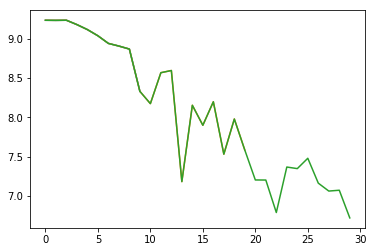

In [10]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
          end_train=50, end_val=20, plot_every=5,save_every=30, batch_size=8)


Train: 7.632281184196472 
Valid: 7.559819889068604



Train: 7.059024691581726 
Valid: 7.211030101776123



Train: 6.614537215232849 
Valid: 6.950641655921936


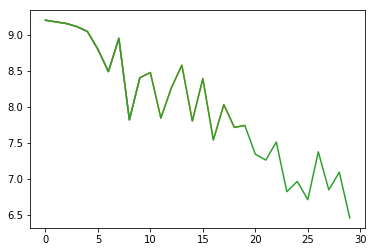

In [35]:
fit_rnnsearch_online(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
                     end_train=50, end_val=20, plot_every=5,save_every=30)

### Analysis

We won't dig deep into the model's workings / performance. For now, we will only look at examples of the model's translations. This will give us some insight into it's capabilities and we will also be able to better interpret the results given by applying custom metric.

##### LSTM RNN

To get new example, simply reload the line below. 

In [12]:
rand_ex = next(iter(valid_iter))
ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)

These two cells show what we are going to translate and it's human translation.

In [13]:
[SRC.vocab.itos[x] for x in ex_src[:,0]]

['mehrere',
 'menschen',
 'stehen',
 'in',
 'der',
 'dämmerung',
 'in',
 'der',
 'nähe',
 'einiger',
 'bäume',
 '<EOS>']

In [14]:
[TRG.vocab.itos[x] for x in ex_trg[:,0]]

['<SOS>',
 'several',
 'people',
 'are',
 'standing',
 'near',
 'trees',
 'at',
 'dusk',
 '<EOS>',
 '<pad>']

Here we use our model to translate the sentence. Choose appropriate translate function (Multi30k, Multi30k_VLS and WMT14 respectively).

In [42]:
sent_ids = translate.Multi30k(enc,dec,trg_sos_id,trg_eos_id,ex_src)

In [16]:
sent_ids = translate.Multi30k_VLS(enc,dec,trg_sos_id,trg_eos_id,pad_src_id,ex_src[:,0][:,None])

In [22]:
sent_ids = translate.WMT14(enc,dec,trg_sos_id,trg_eos_id,ex_src)

Now we can take a look at the sentence our model created.

In [17]:
[TRG.vocab.itos[x] for x in sent_ids]

['several', 'people', 'are', 'people', 'in', 'near', 'a', 'a', 'a', '<EOS>']